In [1]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import tqdm
import scipy.io.wavfile as wav
from speechpy.feature import mfcc
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from keras.utils import np_utils
from sklearn.utils.multiclass import unique_labels

import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


**Process Audio**

In [2]:
columns = ['filenames','labels']

In [3]:
train=pd.read_csv("train.csv",header=None, names=columns)
valid=pd.read_csv("valid.csv",header=None, names=columns)
test=pd.read_csv("test.csv",header=None, names=columns)

In [4]:
print(train.shape, valid.shape, test.shape)

(1470, 2) (491, 2) (491, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 2 columns):
filenames    1470 non-null object
labels       1470 non-null object
dtypes: object(2)
memory usage: 23.0+ KB


In [6]:
train.head()

,filenames,labels
0,03-01-06-01-02-02-23.wav,fear
1,03-01-08-02-02-02-03.wav,surprise
2,03-01-06-01-01-02-24.wav,fear
3,03-01-02-02-01-01-11.wav,calm
4,03-01-07-02-02-02-10.wav,disgust


In [7]:
train_filenames = train['filenames'].values.tolist()
val_filenames = valid['filenames'].values.tolist()
test_filenames = test['filenames'].values.tolist()

In [8]:
print(len(train_filenames))

1470


In [9]:
train_labels = train['labels'].values.tolist()
val_labels = valid['labels'].values.tolist()
test_labels = test['labels'].values.tolist()

In [10]:
FILE_PATH= 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\'
dir_list_speech = os.listdir(FILE_PATH)

In [11]:
#get the paths
dirts = []
filepath_delete = True
for root, dirt,file in os.walk(FILE_PATH):
    if filepath_delete == True:
        print(root, "hahaha")
        filepath_delete = False
    else:
        dirts.append(root) 

C:\Users\ZhaoY\Downloads\DL_Project\unzipped-20200504T003413Z-001\unzipped\ hahaha


In [12]:
#get the files in every path
files = []
for dirt in dirts:
    for root, dt, file in os.walk(dirt):
        for fl in file:
            files.append(os.path.join(dirt,fl))  

In [13]:
len(files)

2452

In [14]:
file_dict = {}
Actor = []
filename = []
    
for file in files:
    filename.append(file.split('\\')[-1])
    file_dict[file.split('\\')[-1]] = file
    Actor.append(file.split('\\')[-2])

In [15]:
file_dict

{'03-01-01-01-01-01-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-02-01-01-01-01.wav',
 '03-01-02-01-01-02-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_01\\03-01-02-01-01-02-01.wav',
 '03-01-02-01-02-01-01.wav': 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzi

In [16]:
def get_file_path(data_set):
    file_path = []
    for file in data_set:
        file_path.append(file_dict[file])
    return file_path

train_file_path = get_file_path(train_filenames)
val_file_path = get_file_path(val_filenames)
test_file_path = get_file_path(test_filenames)

In [17]:
train_file_path

['C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_23\\03-01-06-01-02-02-23.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_03\\03-01-08-02-02-02-03.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_24\\03-01-06-01-01-02-24.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_11\\03-01-02-02-01-01-11.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_10\\03-01-07-02-02-02-10.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_15\\03-01-05-02-02-02-15.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_08\\03-01-03-01-01-02-08.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_11\\03-02-04-02-02-01-11.wav',
 'C:\\Users\\ZhaoY\\Downloads\\D

In [18]:
def get_train_mean_lenth_and_load_file(file_paths):
    mean_signal_length = 0
    signals = []
    for fname in file_paths:
        signal, fs = librosa.load(fname, sr=16000, mono=True)
        mean_signal_length += len(signal)
        signals.append(signal)
    mean_signal_length = int(mean_signal_length/(len(file_paths)))
    return signals, mean_signal_length, fs

In [19]:
train_data, train_mean_feature_length, fs = get_train_mean_lenth_and_load_file(train_file_path)

In [20]:
def load_file(file_paths):
    signals = []
    for fname in file_paths:
        signal, fs = librosa.load(fname, sr=16000, mono=True)
        signals.append(signal)    
    return signals

In [21]:
val_data = load_file(val_file_path)
test_data = load_file(test_file_path)

In [22]:
def get_feature_vector_from_mfcc(signal, mean_signal_length: int, flatten: bool) -> np.ndarray:
    """
    Make feature vector from MFCC for the given wav file.

    Args:
        file_path (str): path to the .wav file that needs to be read.
        flatten (bool) : Boolean indicating whether to flatten mfcc obtained.
        mfcc_len (int): Number of cepestral co efficients to be consider.

    Returns:
        numpy.ndarray: feature vector of the wav file made from mfcc.
    """
    #fs, signal = wav.read(file_path)
    #signal, fs = librosa.load(file_path, sr=16000, mono=True)
    s_len = len(signal)

    # pad the signals to have same size if lesser than required
    # else slice them    
    
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
        
    # sample/frame = mean_signal_length*frame_length
    mel_coefficients = mfcc(signal, fs, frame_length=0.048, frame_stride=0.024, num_filters=30, num_cepstral=30, low_frequency=60, high_frequency=7600)
    if flatten:
        # Flatten the data
        mel_coefficients = np.ravel(mel_coefficients)
    return mel_coefficients

In [23]:
train_features = []
for data in train_data:
    train_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))
    
val_features = []
for data in val_data:
    val_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))

test_features = []
for data in val_data:
    test_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))

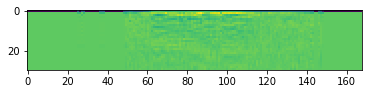

In [24]:
plt.imshow(train_features[0].T)

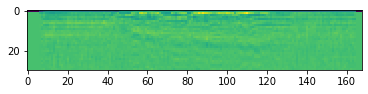

In [25]:
plt.imshow(train_features[19].T)

In [83]:
print((np.array(train_features)).shape)

(1470, 168, 30)


In [26]:
train_features = np.vstack([feature[np.newaxis, :, :] for feature in train_features])
print(train_features.shape)

(1470, 168, 30)


In [27]:
val_features = np.vstack([feature[np.newaxis, :, :] for feature in val_features])
print(val_features.shape)

(491, 168, 30)


In [28]:
test_features = np.vstack([feature[np.newaxis, :, :] for feature in test_features])
print(test_features.shape)

(491, 168, 30)


In [29]:
train_labels[:5]

['fear', 'surprise', 'fear', 'calm', 'disgust']

In [30]:
np.unique(train_labels)

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype='<U8')

In [31]:
train.labels.value_counts()

sad         232
angry       228
happy       224
fear        223
calm        222
disgust     117
surprise    114
neutral     110
Name: labels, dtype: int64

In [32]:
valid.labels.value_counts()

happy       88
calm        76
fear        75
angry       74
sad         67
disgust     43
neutral     42
surprise    26
Name: labels, dtype: int64

In [33]:
test.labels.value_counts()

calm        78
fear        78
sad         77
angry       74
happy       64
surprise    52
neutral     36
disgust     32
Name: labels, dtype: int64

In [34]:
le = LabelEncoder()
le.fit(train_labels)
LabelEncoder()
list(le.classes_)
train_labels = le.transform(train_labels)

le = LabelEncoder()
le.fit(val_labels)
LabelEncoder()
list(le.classes_)
val_labels = le.transform(val_labels)

le = LabelEncoder()
le.fit(test_labels)
LabelEncoder()
list(le.classes_)
test_labels = le.transform(test_labels)

In [35]:
np.unique(val_labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [36]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [37]:
train_labels = np_utils.to_categorical(train_labels)
val_labels = np_utils.to_categorical(val_labels)
test_labels = np_utils.to_categorical(test_labels)

**Process Video**

In [38]:
FILE_PATH= 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/'

In [39]:
#get the paths
dirts_image = []
for root, dirt,file in os.walk(FILE_PATH):
    dirts_image.append(root) 

In [40]:
#get the files in every path
files_image = []
for dirt in dirts_image:
    for root, dt, file in os.walk(dirt):
        for fl in file:
            files_image.append(os.path.join(dirt,fl))  

In [41]:
len(files_image)

2878

In [42]:
files_image[1]

'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-02.mp4.jpg'

In [43]:
file_dict_image = {}
filename_image = []
    
for file in files_image:
    filename_image.append(((file.split('/')[-1]).split('.')[0]))
    file_dict_image[((file.split('/')[-1]).split('.')[0])] = file

In [44]:
file_dict_image

{'01-01-01-01-01-01-01': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-01.mp4.jpg',
 '01-01-01-01-01-01-02': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-02.mp4.jpg',
 '01-01-01-01-01-01-03': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-03.mp4.jpg',
 '01-01-01-01-01-01-04': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-04.mp4.jpg',
 '01-01-01-01-01-01-05': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-05.mp4.jpg',
 '01-01-01-01-01-01-06': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-06.mp4.jpg',
 '01-01-01-01-01-01-07': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-07.mp4.jpg',
 '01-01-01-01-01-01-08': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/01-01-01-01-01-01-08.mp4.jpg',
 '01-01-01-01-01

In [45]:
filename_image_dict = {}
for name in filename_image:
    filename_image_dict[name[3:]] = file_dict_image[name]

In [46]:
filename_image_dict

{'01-01-01-01-01-01': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-01.mp4.jpg',
 '01-01-01-01-01-02': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-02.mp4.jpg',
 '01-01-01-01-01-03': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-03.mp4.jpg',
 '01-01-01-01-01-04': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-04.mp4.jpg',
 '01-01-01-01-01-05': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-05.mp4.jpg',
 '01-01-01-01-01-06': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-06.mp4.jpg',
 '01-01-01-01-01-07': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-07.mp4.jpg',
 '01-01-01-01-01-08': 'C:/Users/ZhaoY/Downloads/DL_Project/Emotion_Images/Emotion_Images/02-01-01-01-01-01-08.mp4.jpg',
 '01-01-01-01-01-09': 'C:/Users/ZhaoY/Do

In [47]:
def extract_perfix(names):
    ret = []
    for name in names:
        ret.append(name.split('.')[0])
    return ret

In [48]:
train_filenames_image = extract_perfix(train_filenames)
val_filenames_image = extract_perfix(val_filenames)
test_filenames_image = extract_perfix(test_filenames)

In [49]:
train_filenames_image

['03-01-06-01-02-02-23',
 '03-01-08-02-02-02-03',
 '03-01-06-01-01-02-24',
 '03-01-02-02-01-01-11',
 '03-01-07-02-02-02-10',
 '03-01-05-02-02-02-15',
 '03-01-03-01-01-02-08',
 '03-02-04-02-02-01-11',
 '03-01-02-01-02-02-15',
 '03-01-02-01-02-02-08',
 '03-01-02-02-01-01-01',
 '03-01-06-01-01-02-19',
 '03-02-04-01-02-01-14',
 '03-01-04-01-02-01-09',
 '03-01-05-02-02-01-10',
 '03-01-07-01-01-02-24',
 '03-02-04-02-01-01-14',
 '03-01-03-01-01-01-13',
 '03-01-06-02-01-02-16',
 '03-01-02-02-01-02-04',
 '03-01-05-02-01-01-12',
 '03-01-08-01-01-01-19',
 '03-01-04-01-01-02-08',
 '03-01-02-01-01-01-02',
 '03-01-05-02-01-01-01',
 '03-01-05-02-02-02-16',
 '03-01-05-01-01-01-14',
 '03-01-07-02-02-01-09',
 '03-02-03-02-01-02-16',
 '03-02-01-01-02-01-13',
 '03-02-02-02-01-01-02',
 '03-02-05-02-01-02-02',
 '03-01-06-01-01-01-06',
 '03-01-05-02-02-02-24',
 '03-02-03-01-01-02-21',
 '03-01-08-02-01-02-15',
 '03-02-06-02-01-01-09',
 '03-01-06-02-02-01-13',
 '03-01-04-01-02-02-03',
 '03-01-08-01-02-02-14',


In [50]:
def extract_name_nperfix(filenms):
    names = []
    for name in filenms:
        names.append(name[3:])
    return names

train_match_name = extract_name_nperfix(train_filenames_image)
val_match_name   = extract_name_nperfix(val_filenames_image)
test_match_name   = extract_name_nperfix(test_filenames_image)

In [51]:
train_match_name[-1]

'02-02-02-02-02-10'

In [72]:
def file_path_extract(names):
    ret = []
    ret_audio = []
    delete_file = []
    for f in names:
        if f in filename_image_dict.keys():
            ret.append(filename_image_dict[f])
            ret_audio.append(f)
        else:
            delete_file.append(f)
    return ret, delete_file, ret_audio

In [73]:
train_pt_image, train_delete, train_audio = file_path_extract(train_match_name)
val_pt_image, val_delete, val_audio = file_path_extract(val_match_name)
test_pt_image, test_delete, test_audio = file_path_extract(test_match_name)

In [74]:
print(len(train_delete))
print(len(val_delete))
print(len(test_delete))

610
207
195


In [75]:
print(len(train_pt_image))
print(len(val_pt_image))
print(len(test_pt_image))

860
284
296


In [77]:
print(len(train_pt_image[0]))
print(len(val_pt_image[0]))
print(len(test_pt_image[0]))

94
94
94


In [76]:
train_audio[:2]

['01-06-01-02-02-23', '01-08-02-02-02-03']

In [93]:
def extrct_all_labels(files):
    labels = []
    for file in files:
        labels.append(int(file.split("-")[1])-1)
    return labels

In [94]:
train_all_labels = extrct_all_labels(train_audio)
val_all_labels = extrct_all_labels(val_audio)
test_all_labels = extrct_all_labels(test_audio)

In [95]:
print(len(train_all_labels))
print(len(val_all_labels))
print(len(test_all_labels))

860
284
296


In [110]:
train_all_labels = np_utils.to_categorical(train_all_labels)
val_all_labels = np_utils.to_categorical(val_all_labels)
test_all_labels = np_utils.to_categorical(test_all_labels)

In [111]:
train_all_labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [54]:
def load_images(image_paths, size=(224, 224)):
    images = []
    for fname in tqdm(image_paths):
        if os.path.exists(fname):
            # read the image
            image = cv2.imread(fname, 1)
            # resize it to 224x224
            image = cv2.resize(image, (224, 224))
            #convert it to grayscale
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # store it
            images.append(image)
        else:
            images.append(None)
    return images

In [78]:
train_images = load_images(train_pt_image)
val_images = load_images(val_pt_image)
test_images = load_images(test_pt_image)

100%|██████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 1104.71it/s]


In [82]:
print((np.array(train_images)).shape)

(860, 224, 224, 3)


In [64]:
def features_to_np_array(images):
    return np.vstack([image[np.newaxis, :, :, :] for image in images])

In [66]:
train_images = features_to_np_array(train_images)
val_images = features_to_np_array(val_images)
test_images = features_to_np_array(test_images)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(860, 224, 224, 3)
(284, 224, 224, 3)
(296, 224, 224, 3)


In [100]:
def get_full_filename_back(files):
    new_f = []
    for file in files:
        new_f.append('{}{}{}'.format('03-', file, '.wav'))
    return new_f

In [103]:
trains = get_full_filename_back(train_audio)
vals = get_full_filename_back(val_audio)
tests = get_full_filename_back(test_audio)

In [104]:
trains[:5]

['03-01-06-01-02-02-23.wav',
 '03-01-08-02-02-02-03.wav',
 '03-01-06-01-01-02-24.wav',
 '03-01-02-02-01-01-11.wav',
 '03-01-07-02-02-02-10.wav']

In [106]:
train_file_path = get_file_path(trains)
val_file_path = get_file_path(vals)
test_file_path = get_file_path(tests)

In [108]:
train_file_path[:4]

['C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_23\\03-01-06-01-02-02-23.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_03\\03-01-08-02-02-02-03.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_24\\03-01-06-01-01-02-24.wav',
 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\unzipped-20200504T003413Z-001\\unzipped\\Actor_11\\03-01-02-02-01-01-11.wav']

In [109]:
train_data, train_mean_feature_length, fs = get_train_mean_lenth_and_load_file(train_file_path)

In [113]:
val_data = load_file(val_file_path)
test_data = load_file(test_file_path)

In [119]:
train_features = []
for data in train_data:
    train_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))
    
val_features = []
for data in val_data:
    val_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))

test_features = []
for data in test_data:
    test_features.append(get_feature_vector_from_mfcc(data, train_mean_feature_length, flatten=False))

In [120]:
print((np.array(train_features)).shape)
print((np.array(val_features)).shape)
print((np.array(test_features)).shape)

(860, 152, 30)
(284, 152, 30)
(296, 152, 30)


In [121]:
print((np.array(train_images)).shape)
print((np.array(val_images)).shape)
print((np.array(test_images)).shape)

(860, 224, 224, 3)
(284, 224, 224, 3)
(296, 224, 224, 3)


In [123]:
train_features = np.array(train_features).reshape(860, 4560)
val_features =  np.array(val_features).reshape(284, 4560)
test_features =  np.array(test_features).reshape(296, 4560)
train_images =  np.array(train_images).reshape(860, 150528)
val_images =  np.array(val_images).reshape(284, 150528)
test_images =  np.array(test_images).reshape(296, 150528)

In [124]:
train_features.shape

(860, 4560)

In [125]:
train_images.shape

(860, 150528)

In [127]:
train_final_features = np.hstack([train_features, train_images])
val_final_features = np.hstack([val_features, val_images])
test_final_features = np.hstack([test_features, test_images])

In [130]:
print(train_final_features.shape)
print(val_final_features.shape)
print(test_final_features.shape)

(860, 155088)
(284, 155088)
(296, 155088)


In [139]:
train_all_labels.shape[1]

8

In [131]:
def build_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Dense(64, input_shape=input_shape, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [144]:
model = build_model(input_shape=(train_final_features.shape[1],), num_classes=train_all_labels.shape[1])

In [145]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.2,
                               patience=5,
                               min_lr=1e-6,
                               verbose=1)

In [147]:
hist = model.fit(train_final_features, train_all_labels, batch_size=32, epochs=50, validation_data=(val_final_features, val_all_labels), callbacks=[lr_reducer])

Train on 860 samples, validate on 284 samples
Epoch 1/50
860/860 [==============================] - 3s 3ms/sample - loss: 2.4764 - accuracy: 0.1116 - val_loss: 2.2863 - val_accuracy: 0.0704
Epoch 2/50
860/860 [==============================] - 3s 4ms/sample - loss: 2.4782 - accuracy: 0.1000 - val_loss: 2.2371 - val_accuracy: 0.1655
Epoch 3/50
860/860 [==============================] - 3s 4ms/sample - loss: 2.4058 - accuracy: 0.1093 - val_loss: 2.1913 - val_accuracy: 0.1655
Epoch 4/50
860/860 [==============================] - 3s 4ms/sample - loss: 2.3468 - accuracy: 0.1151 - val_loss: 2.1531 - val_accuracy: 0.1655
Epoch 5/50
860/860 [==============================] - 3s 3ms/sample - loss: 2.2914 - accuracy: 0.1128 - val_loss: 2.1233 - val_accuracy: 0.1655
Epoch 6/50
860/860 [==============================] - 4s 4ms/sample - loss: 2.3011 - accuracy: 0.1233 - val_loss: 2.1688 - val_accuracy: 0.1690
Epoch 7/50
860/860 [==============================] - 3s 4ms/sample - loss: 2.3048 - accur

In [148]:
def draw_hist(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.figure(figsize=(8, 4.5))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # clear figure
    acc_values = acc
    val_acc_values = val_acc

    plt.figure(figsize=(8, 4.5))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [149]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    print('unique labels:', unique_labels(y_true, y_pred))
    classes = np.array(classes)[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    fig.set_figheight(9)
    fig.set_figwidth(9)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

2.080602658761514 0.11486486
Classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        42
           4       0.11      1.00      0.21        34
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        52

    accuracy                           0.11       296
   macro avg       0.01      0.12      0.03       296
weighted avg       0.01      0.11      0.02       296

Confusion matrix: 
[[ 0  0  0  0 22  0  0  0]
 [ 0  0  0  0 39  0  0  0]
 [ 0  0  0  0 33  0  0  0]
 [ 0  0  0  0 42  0  0  0]
 [ 0  0  0  0 34  0  0  0]
 [ 0  0  0  0 42  0  0  0]
 [ 0  0  0  0 32  0  0  0]
 [ 0  0  0  0 52  0  0  0]]


C:\Users\ZhaoY\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


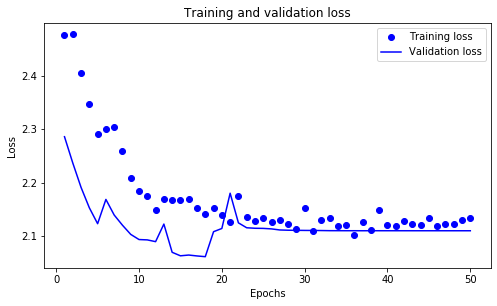

<Figure size 432x288 with 0 Axes>

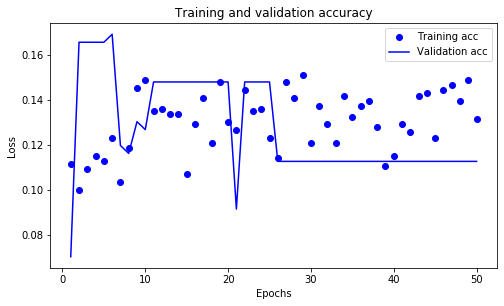

unique labels: [0 1 2 3 4 5 6 7]
Normalized confusion matrix


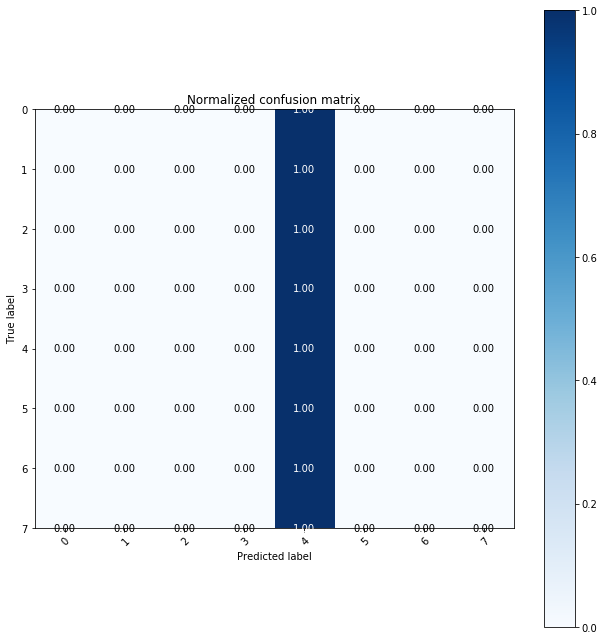

In [152]:
test_loss, test_acc = model.evaluate(test_final_features, test_all_labels, verbose=0)
print(test_loss, test_acc)
pred_labels = model.predict(test_final_features)
print('Classification report: ')
print(classification_report(np.argmax(test_all_labels, axis=1), np.argmax(pred_labels, axis=1)))
print('Confusion matrix: ')
print(confusion_matrix(np.argmax(test_all_labels, axis=1), np.argmax(pred_labels, axis=1)))
draw_hist(hist) 
plot_confusion_matrix(np.argmax(test_all_labels, axis=1), np.argmax(pred_labels, axis=1), normalize=True, classes=[str(i) for i in range(10)])